# E-Commerce Shipping Analysis

> Sebuah perusahaan e-commerce internasional yang bergerak di bidang elektronik ingin mengungkap insight penting dari database pelanggan mereka dengan memanfaatkan teknik Machine Learning.

## **1. Business Understanding**

Dataset ini berasal dari sebuah perusahaan e-commerce yang menyediakan jasa pengiriman barang. Tujuan utama dari proyek ini adalah untuk menganalisis keterlambatan pengiriman (delivery delay) dan faktor-faktor yang mempengaruhinya. Dengan memahami variabel-variabel yang berkontribusi terhadap keterlambatan, perusahaan dapat meningkatkan efisiensi logistik dan kepuasan pelanggan.

Target analisis:
- Memprediksi apakah suatu pengiriman akan tepat waktu
- Menghitung kerugian perusahaan sebelum menggunakan model dengan sesudah menggunakan model.
- Mengidentifikasi faktor-faktor yang paling mempengaruhi keterlambatan.

Matriks Evaluasi:
### ⚠️ False Positive (FP):
- **Prediksi:** Barang akan terlambat sampai
- **Aktual:** Barang tepat waktu sampai
- **Dampak:**
    + Diasumsikan perusahaan akan memberikan voucher/refund jika barang datang terlambat namun hanya jika benar-benar datang terlambat voucher/refund tersebut dapat diklaim.
    + Kemungkinan pelanggan tidak jadi membeli karena produk datang terlalu lama.
- 💸 Estimasi kerugian: 0 (karena barang datang tepat waktu maka tidak ada kompensasi yang harus diberikan)

### ❌ False Negative (FN):
- **Prediksi:** Barang akan tepat waktu sampai
- **Aktual:** Barang terlambat sampai
- **Dampak:** 
    + Tidak ada tindakan pencegahan atau pemberitahuan ke pelanggan -> pelanggan kecewa
    + Potensi penalti SLA (Service Level Agreement) dari mitra logistik
    + Kehilangan kepercayaan pelanggan dan kemungkinan churn
- 💸 Estimasi kerugian: ± **$300 per pengiriman** (gabungan SLA penalty, kompensasi, dan hilangnya pelanggan)


> Maka dalam kasus ini, False Negative lebih merugikan karena perusahaan gagal mengantisipasi keterlambatan, yang langsung berdampak pada kepercayaan dan potensi kerugian besar.
Inilah sebabnya Recall (menghindari FN) penting dalam model prediksi ini.

In [1]:
# import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# data splitting
from sklearn.model_selection import train_test_split

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder, OrdinalEncoder

# missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# binning
from sklearn.preprocessing import KBinsDiscretizer

# polynomial features
from sklearn.preprocessing import PolynomialFeatures

# column transfornmer
from sklearn.compose import ColumnTransformer

# pipeline
from sklearn.pipeline import Pipeline

# imbalanced
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

# cross validation
from sklearn.model_selection import cross_val_score

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# modeling
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# modeling -> ensemble various type
from sklearn.ensemble import VotingClassifier, StackingClassifier

# ensemble similar type
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# selalu dipakai ketika ingin pakai pipeline tetapi ada step balancing data
from imblearn.pipeline import Pipeline

from xgboost.sklearn import XGBClassifier   

import warnings
# Nonaktifkan semua warning
warnings.filterwarnings("ignore")

# joblib
import joblib

# lime
import lime
from lime import lime_tabular

## **2. Data Understanding**

Dataset ini didapatkan dari: [E-Commerce Shipping Data](https://www.kaggle.com/datasets/prachi13/customer-analytics)

In [2]:
df = pd.read_csv('E-Commerce Shipping Data.csv')
df.head(5)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


| Kolom                 | Tipe Data | Deskripsi                                                                                                                     |
| --------------------- | --------- | ----------------------------------------------------------------------------------------------------------------------------- |
| `ID`                  | Integer   | ID unik dari transaksi pengiriman.                                                                                            |
| `Warehouse_block`     | Object    | Lokasi gudang tempat pengiriman dimulai (misal: A, B, C, D, F).                                                               |
| `Mode_of_Shipment`    | Object    | Metode pengiriman: `Flight`, `Ship`, atau `Road`.                                                                             |
| `Customer_care_calls` | Integer   | Jumlah panggilan pelanggan ke layanan pelanggan.                                                                              |
| `Customer_rating`     | Integer   | Rating dari pelanggan terhadap layanan (1–5).                                                                                 |
| `Cost_of_the_Product` | Integer   | Harga produk dalam satuan mata uang lokal.                                                                                    |
| `Prior_purchases`     | Integer   | Jumlah pembelian sebelumnya oleh pelanggan.                                                                                   |
| `Product_importance`  | Object    | Tingkat kepentingan produk: `low`, `medium`, atau `high`.                                                                     |
| `Gender`              | Object    | Jenis kelamin pelanggan: `M` atau `F`.                                                                                        |
| `Discount_offered`    | Integer   | Diskon yang ditawarkan pada produk.                                                                                           |
| `Weight_in_gms`       | Integer   | Berat produk dalam gram.                                                                                                      |
| `Reached.on.Time_Y.N` | Integer   | Apakah produk sampai tepat waktu (`1`) atau terlambat (`0`). Ini adalah **kolom target** jika ingin membangun model prediksi. |


In [3]:
df['Reached.on.Time_Y.N'].value_counts(normalize = True)

Reached.on.Time_Y.N
1    0.596691
0    0.403309
Name: proportion, dtype: float64

Insight

> Proporsi barang yang `terlambat` dengan barang yang `tidak terlambat` tidak jauh perbedaannya, sehingga data bisa dikatakan sudah balance.

## **3. Data Cleansing**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [5]:
df['ID'] = df['ID'].astype('object')
df['Warehouse_block'] = df['Warehouse_block'].astype('category')
df['Mode_of_Shipment'] = df['Mode_of_Shipment'].astype('category')
df['Product_importance'] = df['Product_importance'].astype('category')
df['Gender'] = df['Gender'].astype('category')

In [6]:
df.isna().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

In [7]:
df.duplicated().sum()

0

Data sudah tidak ada missing values dan duplikat.

## **4. EDA**

In [8]:
# Cek nilai unik untuk tiap kolom kategorikal, kecuali CustomerID
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.drop('ID', errors='ignore')

for col in categorical_columns:
    print(f"Kolom: {col}")
    print(df[col].value_counts(dropna=False))
    print("="*40)

Kolom: Warehouse_block
Warehouse_block
F    3666
D    1834
A    1833
B    1833
C    1833
Name: count, dtype: int64
Kolom: Mode_of_Shipment
Mode_of_Shipment
Ship      7462
Flight    1777
Road      1760
Name: count, dtype: int64
Kolom: Product_importance
Product_importance
low       5297
medium    4754
high       948
Name: count, dtype: int64
Kolom: Gender
Gender
F    5545
M    5454
Name: count, dtype: int64


=== Ringkasan Statistik ===
       Customer_care_calls  Customer_rating  Cost_of_the_Product  \
count         10999.000000     10999.000000         10999.000000   
mean              4.054459         2.990545           210.196836   
std               1.141490         1.413603            48.063272   
min               2.000000         1.000000            96.000000   
25%               3.000000         2.000000           169.000000   
50%               4.000000         3.000000           214.000000   
75%               5.000000         4.000000           251.000000   
max               7.000000         5.000000           310.000000   

       Prior_purchases  Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
count     10999.000000      10999.000000   10999.000000         10999.000000  
mean          3.567597         13.373216    3634.016729             0.596691  
std           1.522860         16.205527    1635.377251             0.490584  
min           2.000000          1.000000   

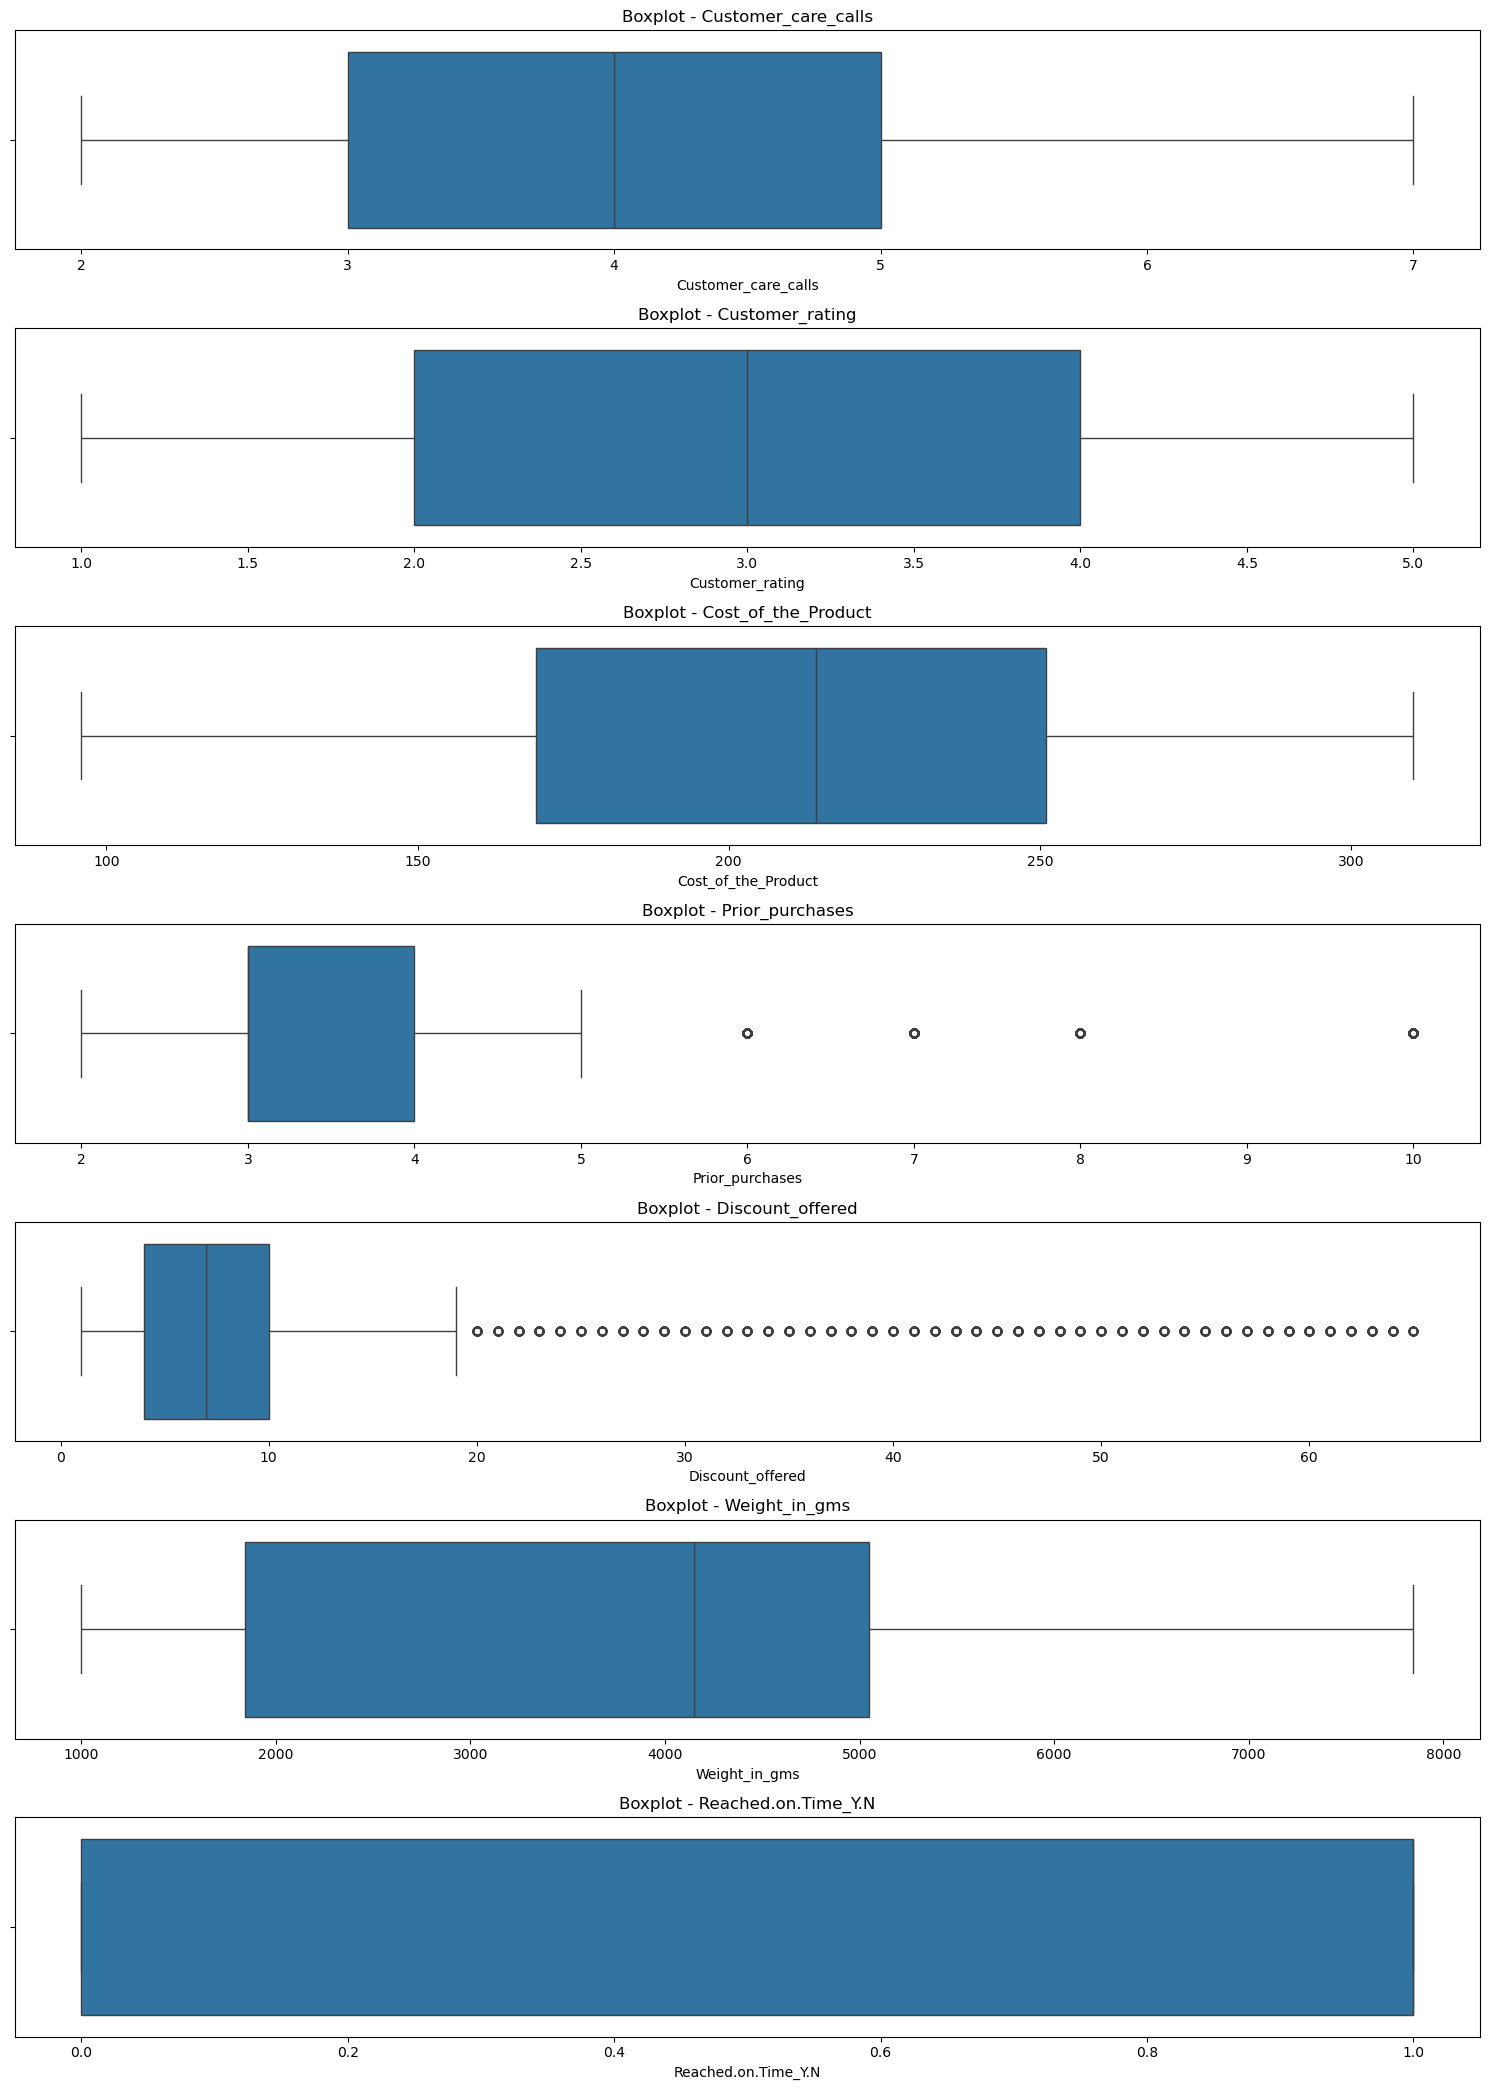

In [9]:
# Identifikasi kolom numerikal
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Descriptive statistics
print("=== Ringkasan Statistik ===")
print(df[numerical_columns].describe())
print("\n")

# Boxplots untuk semua kolom numerik
plt.figure(figsize=(15, len(numerical_columns) * 3))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()

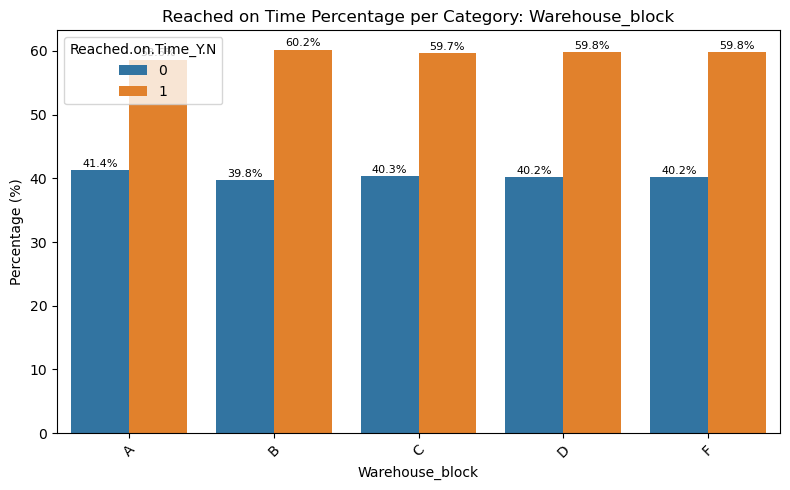

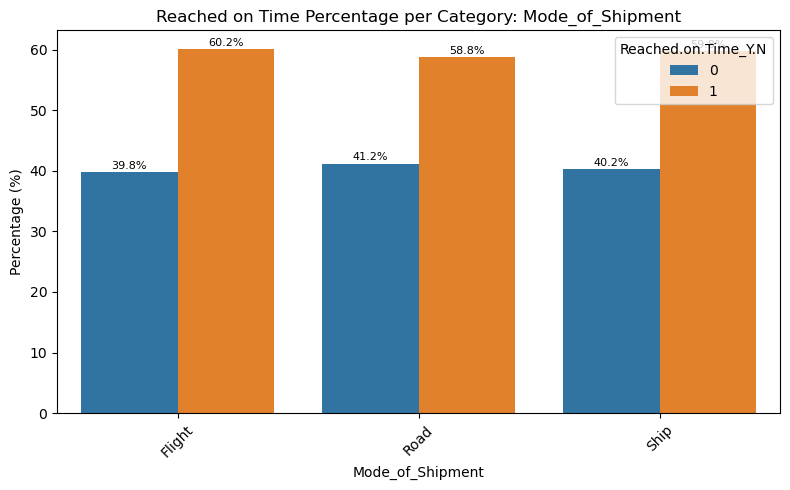

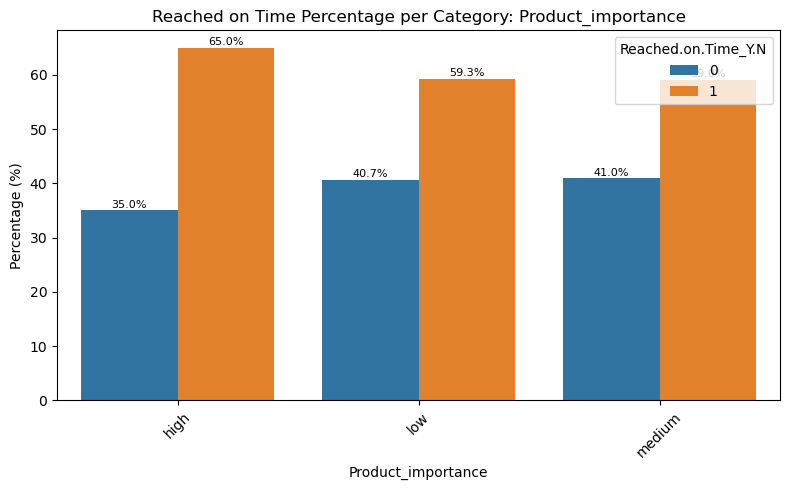

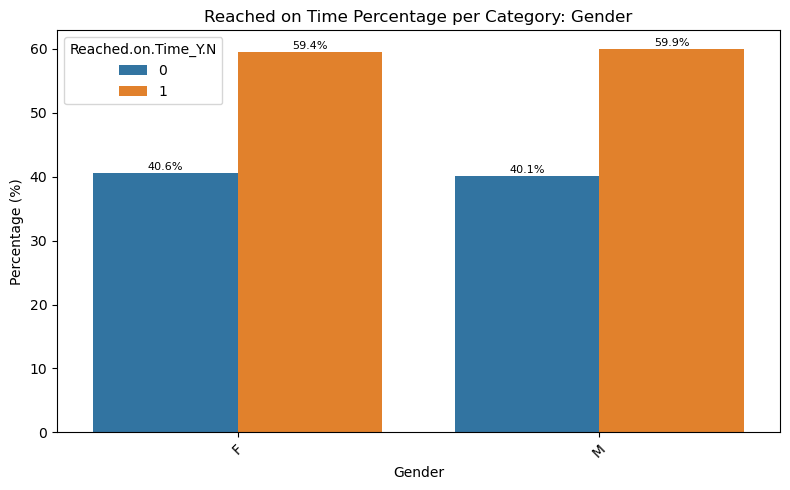

In [10]:
cat_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']

for col in cat_cols:
    # Hitung jumlah & persentase Reached.on.Time per kategori
    prop_df = df.groupby([col, 'Reached.on.Time_Y.N']).size().reset_index(name='count')
    prop_df['percent'] = 100 * prop_df['count'] / prop_df.groupby(col)['count'].transform('sum')
    
    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=prop_df, x=col, y='percent', hue='Reached.on.Time_Y.N')
    
    # Tambahkan label di atas bar
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 1:  # biar label gak numpuk di 0%
            plt.text(p.get_x() + p.get_width()/2., height + 0.5, f'{height:.1f}%', 
                     ha="center", fontsize=8)
    
    plt.title(f'Reached on Time Percentage per Category: {col}')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Distribusi kategori:
- Mode_of_Shipment: didominasi oleh Ship.
- Product_importance: didominasi oleh low.
- Gender: seimbang antara M dan F.
- Beberapa kolom seperti Discount_offered dan Weight_in_gms memiliki rentang cukup lebar, tapi ini masih masuk akal secara bisnis.

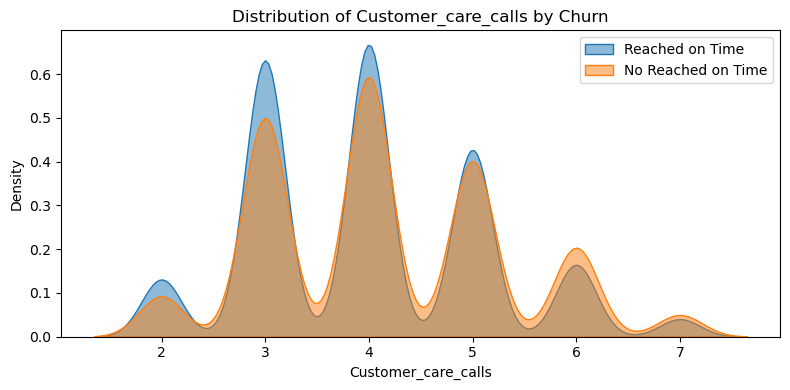

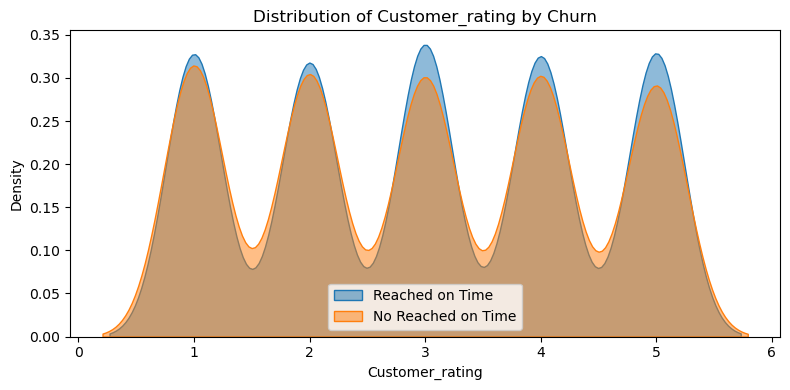

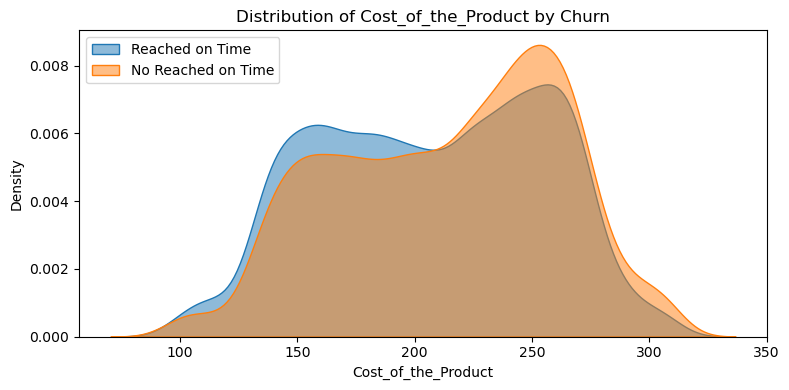

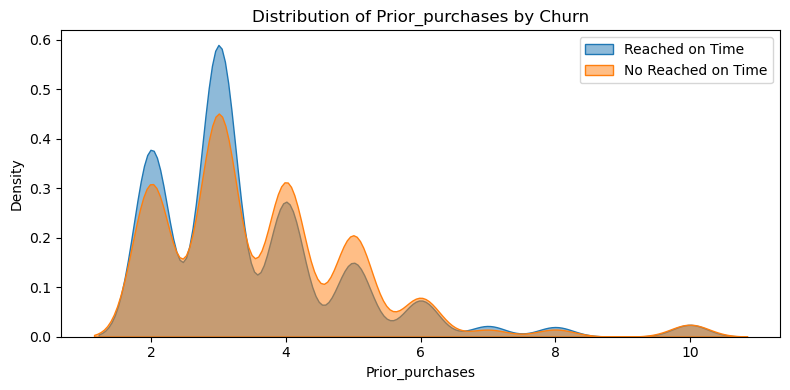

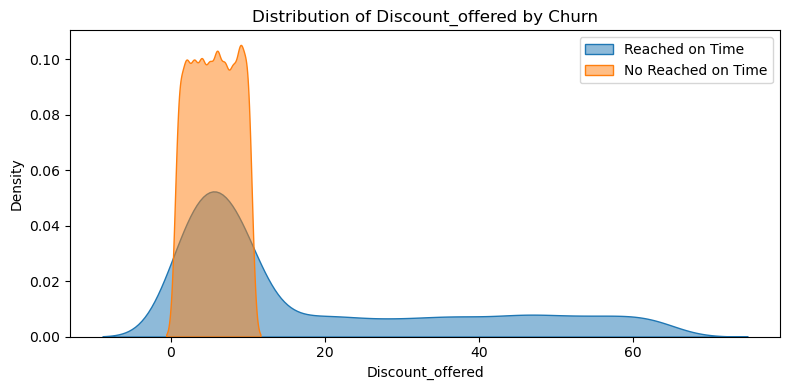

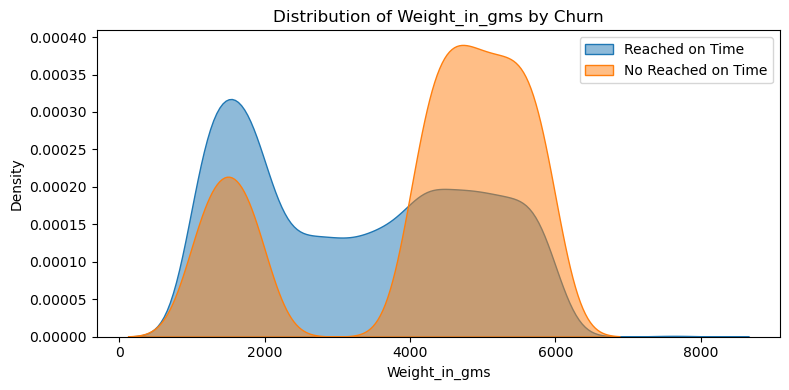

In [11]:
num_cols = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df[df['Reached.on.Time_Y.N'] == 1], x=col, label='Reached on Time', fill=True, alpha=0.5)
    sns.kdeplot(data=df[df['Reached.on.Time_Y.N'] == 0], x=col, label='No Reached on Time', fill=True, alpha=0.5)
    plt.title(f'Distribution of {col} by Churn')
    plt.legend()
    plt.tight_layout()
    plt.show()

## **5. Data Pre-Processing**

### 1. Define X dan y

In [12]:
df2 = df.copy()

In [13]:
X = df2.drop(columns = ['ID', 'Reached.on.Time_Y.N'])
y = df2['Reached.on.Time_Y.N']

### 2. Encoding dan Scaling

Encoding:
- `Warehouse_block` = onehot
- `Mode_of_Shipment` = onehot
- `Product_importance` = Label encoding
- `Gender` = Label encoding

In [14]:
# Label Encoding
X['Product_importance'] = X['Product_importance'].map({'low' : 0, 'medium' : 1, 'high' : 2})
X['Gender'] = X['Gender'].map({'F' : 0, 'M' : 1})

In [15]:
# pipeline transformasi
transformer = ColumnTransformer([
    ("onehot", OneHotEncoder(drop='first'), ['Warehouse_block', 'Mode_of_Shipment']), 
    ('robust', RobustScaler(), ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
       'Prior_purchases', 'Discount_offered',
       'Weight_in_gms'])
], remainder = 'passthrough')

### 3. Train Test Splitting

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

## **6. Modeling Benchmark**

### 1. Define Model

In [17]:
# define model
logreg = LogisticRegression(random_state=8)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=8)

# ensemble various
voting = VotingClassifier(estimators=[('clf1', logreg),
                                      ('clf2', knn),
                                      ('clf3', tree)])   # base learner

stacking = StackingClassifier(estimators=[('logreg', logreg),
                                      ('knn', knn),
                                      ('tree', tree)],
                                      final_estimator=LogisticRegression(random_state=42),)

# ensemble similar
bagging = BaggingClassifier(random_state=8, estimator=KNeighborsClassifier(), n_estimators=100)
rf = RandomForestClassifier(random_state=8) # bagging
adaboost = AdaBoostClassifier(random_state=8) # boosting

gboost = GradientBoostingClassifier(random_state = 42) 
xgboost = XGBClassifier(random_state = 42)

### 2. Cross Validation

In [ ]:
list_model = [logreg, knn, tree, voting, stacking, bagging, rf, adaboost, gboost, xgboost]
list_all_score = []
list_mean_score = [] # rata-rata skor
list_std = [] # std, serendah mungkin biar konsisten

for model in list_model:
    # pipeline
    pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('modeling', model)
    ])

    # cross val
    crossval = cross_val_score(estimator=pipe_prep_model,
                    X = X_train,
                    y = y_train,
                    cv = 5,
                    scoring = 'recall')

    # recall
    list_all_score.append(crossval.round(2))
    list_mean_score.append(crossval.mean())
    list_std.append(crossval.std())

In [19]:
df_recall_b = pd.DataFrame()
df_recall_b['algo'] = list_model
df_recall_b['all_score'] = list_all_score
df_recall_b['mean_score'] = list_mean_score
df_recall_b['std_score'] = list_std
df_recall_b

,algo,all_score,mean_score,std_score
0,LogisticRegression(random_state=8),"[0.67, 0.69, 0.65, 0.67, 0.7]",0.676496,0.017373
1,KNeighborsClassifier(),"[0.68, 0.67, 0.64, 0.65, 0.67]",0.661663,0.012745
2,DecisionTreeClassifier(random_state=8),"[0.7, 0.71, 0.68, 0.68, 0.73]",0.698940,0.017788
3,"VotingClassifier(estimators=[('clf1', Logistic...","[0.68, 0.69, 0.64, 0.65, 0.69]",0.673075,0.020614
4,"StackingClassifier(estimators=[('logreg', Logi...","[0.7, 0.73, 0.68, 0.69, 0.73]",0.705975,0.020395
5,BaggingClassifier(estimator=KNeighborsClassifi...,"[0.67, 0.66, 0.64, 0.64, 0.67]",0.655958,0.013550
6,RandomForestClassifier(random_state=8),"[0.65, 0.67, 0.61, 0.6, 0.63]",0.630851,0.025998
7,AdaBoostClassifier(random_state=8),"[0.62, 0.63, 0.6, 0.58, 0.63]",0.611264,0.018882
8,GradientBoostingClassifier(random_state=42),"[0.57, 0.58, 0.52, 0.52, 0.56]",0.549833,0.024066
9,"XGBClassifier(base_score=None, booster=None, c...","[0.67, 0.69, 0.63, 0.65, 0.66]",0.661849,0.019804


## **7. Cross Validation + Resampling**

In [20]:
# resampling
smote = SMOTE(sampling_strategy='minority', random_state=8)
near = NearMiss()

In [21]:
list_resampling = [smote, near]
list_resampling_name = ['SMOTE', 'NearMiss']
list_model = [logreg, knn, tree, voting, stacking, bagging, rf, adaboost, gboost, xgboost]
list_model_name = ['LogReg', 'KNN', 'Tree', 'Voting', 'Stacking', 'Bagging', 'RF', 'AdaBoost', 'GBoost', 'XGBoost']

results = []

for resampler, resample_name in zip(list_resampling, list_resampling_name):
    for model, model_name in zip(list_model, list_model_name):
        # pipeline
        pipe_prep_model =  Pipeline([
            ('preprocessing', transformer),
            ('resampling', resampler),
            ('modeling', model)
        ])

        # cross val
        crossval = cross_val_score(estimator=pipe_prep_model,
                    X = X_train,
                    y = y_train,
                    cv = 5,
                    scoring = 'recall')
        
        results.append({
            'model': model_name,
            'resampler': resample_name,
            'scores': crossval.round(2),
            'mean': crossval.mean(),
            'std': crossval.std()
            })

In [22]:
df_results = pd.DataFrame(results)
df_results

,model,resampler,scores,mean,std
0,LogReg,SMOTE,"[0.52, 0.54, 0.5, 0.51, 0.53]",0.519211,0.013958
1,KNN,SMOTE,"[0.59, 0.6, 0.57, 0.57, 0.6]",0.585778,0.014800
2,Tree,SMOTE,"[0.7, 0.71, 0.67, 0.68, 0.7]",0.692282,0.017269
3,Voting,SMOTE,"[0.57, 0.57, 0.53, 0.54, 0.57]",0.557632,0.016976
4,Stacking,SMOTE,"[0.62, 0.63, 0.58, 0.58, 0.63]",0.607462,0.021406
5,Bagging,SMOTE,"[0.58, 0.59, 0.56, 0.56, 0.59]",0.574556,0.012483
6,RF,SMOTE,"[0.62, 0.64, 0.57, 0.56, 0.6]",0.596999,0.030498
7,AdaBoost,SMOTE,"[0.53, 0.54, 0.49, 0.49, 0.54]",0.518264,0.020945
8,GBoost,SMOTE,"[0.53, 0.54, 0.5, 0.5, 0.54]",0.522447,0.018597
9,XGBoost,SMOTE,"[0.65, 0.67, 0.63, 0.63, 0.64]",0.645113,0.017103


> Model yang dipilih adalah `StackingClassifier` sebelum resampling

## **8. Hyperparameter Tuning**

- **Tuning model Stacking Classifier**

In [31]:
# pipeline
pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('modeling', stacking)
    ])

hyperparam = {
    # Meta-learner (Logistic Regression)
    'modeling__final_estimator__C': [0.01, 0.1, 1.0],  # Lebih banyak opsi regularisasi

    # KNN (kurangi kompleksitas)
    'modeling__knn__n_neighbors': [3, 5, 7],  # Lebih banyak neighbor untuk data besar
    'modeling__knn__weights': ['uniform', 'distance'],  # Hanya gunakan distance (uniform kurang optimal untuk data besar)
    
    # Decision Tree (batasi kompleksitas)
    'modeling__tree__max_depth': [3, 5, 10], 
    'modeling__tree__min_samples_split': [10, 20, 50],  # Nilai lebih besar untuk hindari overfitting
    'modeling__tree__min_samples_leaf': [5, 10, 20],
    'modeling__tree__max_features': ['sqrt', 0.5],  # Kurangi feature tiap split
    
    # Konfigurasi Stacking
    'modeling__passthrough': [False],  # Nonaktifkan untuk data besar
    'modeling__stack_method': ['predict_proba']  # Hanya gunakan yang tercepat
}

# randomsearch
randomsearch = RandomizedSearchCV( 
    estimator= pipe_prep_model,
    param_distributions= hyperparam,
    cv= 5,
    scoring='recall',
    n_jobs=-1,
    n_iter= 100,
    random_state= 42
)

In [32]:
randomsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Warehouse_block',
                                                                                'Mode_of_Shipment']),
                                                                              ('robust',
                                                                               RobustScaler(),
                                                                               ['Customer_care_calls',
                                                                                'Customer_rating',
                                                                                'Cost_of_the_Product',
                                                                                'Prior_purchases',
                                                                                'Discount_offered',
                                                                                'Weight_in_gms'])])),
                                             ('m...
                                        'modeling__knn__n_neighbors': [3, 5, 7],
                                        'modeling__knn__weights': ['uniform',
                                                                   'distance'],
                                        'modeling__passthrough': [False],
                                        'modeling__stack_method': ['predict_proba'],
                                        'modeling__tree__max_depth': [3, 5, 10],
                                        'modeling__tree__max_features': ['sqrt',
                                                                         0.5],
                                        'modeling__tree__min_samples_leaf': [5,
                                                                             10,
                                                                             20],
                                        'modeling__tree__min_samples_split': [10,
                                                                              20,
                                                                              50]},
                   random_state=42, scoring='recall')

In [39]:
randomsearch.best_score_

0.771781717936566

In [34]:
randomsearch.best_params_

{'modeling__tree__min_samples_split': 10,
 'modeling__tree__min_samples_leaf': 10,
 'modeling__tree__max_features': 0.5,
 'modeling__tree__max_depth': 3,
 'modeling__stack_method': 'predict_proba',
 'modeling__passthrough': False,
 'modeling__knn__weights': 'uniform',
 'modeling__knn__n_neighbors': 5,
 'modeling__final_estimator__C': 0.01}

## **9. Predict to Test Set**

### Before Tuning

In [41]:
# pipeline
pipe_prep_model =  Pipeline([
        ('preprocessing', transformer),
        ('modeling', stacking)
    ])

# fit
pipe_prep_model.fit(X_train, y_train)

# predict
y_pred_before = pipe_prep_model.predict(X_test)

# f1
recall_score(y_test, y_pred_before)

0.7126436781609196

### After Tuning

In [42]:
# best model
best_model = randomsearch.best_estimator_

# fit
best_model.fit(X_train, y_train)

# predict
y_pred_after = best_model.predict(X_test)

# f1
recall_score(y_test, y_pred_after)

0.7478927203065134

## **10. Hasil Akhir**

### Classification Report

In [43]:
print('Stacking Before Tuning')
print(classification_report(y_test, y_pred_before))

Stacking Before Tuning
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       895
           1       0.70      0.71      0.70      1305

    accuracy                           0.64      2200
   macro avg       0.63      0.63      0.63      2200
weighted avg       0.64      0.64      0.64      2200



In [44]:
print('Stacking After Tuning')
print(classification_report(y_test, y_pred_after))

Stacking After Tuning
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       895
           1       0.68      0.75      0.71      1305

    accuracy                           0.64      2200
   macro avg       0.62      0.61      0.61      2200
weighted avg       0.63      0.64      0.63      2200



### Confusion Matrix

In [4]:
plt.figure(figsize=(12,4))
sns.heatmap(confusion_matrix(y_test, y_pred_after), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('Stacking after tuning');

NameError: name 'plt' is not defined

Insight: 
- Total_FP_Loss = 467 × 0 = 0
- Total_FN_Loss = 329 × $300 = $98.700

- Total_Kerugian = Total_FP_Loss + Total_FN_Loss
                = 0 + Rp $98.700
                = $98.700


- ✅ Sebelum Membentuk Model:
    + Kita tidak bisa mendeteksi keterlambatan, sehingga semua 4436 kasus keterlambatan berjalan tanpa intervensi.
    + Total kerugian: 4436 x $300 = $1.330.800

## **11. Save Model Final**

In [53]:
# Simpan
joblib.dump(best_model, 'stacking_model.joblib')

# Load
model_loaded = joblib.load('stacking_model.joblib')

## **12. Interpretasi Model**

In [54]:
best_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Warehouse_block',
                                                   'Mode_of_Shipment']),
                                                 ('robust', RobustScaler(),
                                                  ['Customer_care_calls',
                                                   'Customer_rating',
                                                   'Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Discount_offered',
                                                   'Weight_in_gms'])])),
                ('modeling',
                 StackingClassifier(estimators=[('logreg',
                                                 LogisticRegression(random_state=8)),
                                                ('knn', KNeighborsClassifier()),
                                                ('tree',
                                                 DecisionTreeClassifier(max_depth=3,
                                                                        max_features=0.5,
                                                                        min_samples_leaf=10,
                                                                        min_samples_split=10,
                                                                        random_state=8))],
                                    final_estimator=LogisticRegression(C=0.01,
                                                                       random_state=42),
                                    stack_method='predict_proba'))])

In [57]:
df.head(2)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1


In [66]:
# Ambil model dan data dari pipeline dengan named_steps
my_model = best_model[-1]
my_data = best_model[0].transform(X_train)


In [80]:
# Ambil nama kolom original
cat_cols = ['Warehouse_block', 'Mode_of_Shipment']
num_cols = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product',
            'Prior_purchases', 'Discount_offered', 'Weight_in_gms']

# Ambil feature names dari onehotencoder
onehot = transformer.named_transformers_['onehot']
onehot_features = onehot.get_feature_names_out(cat_cols)

feat_remainder = list(X.columns[best_model['preprocessing'].transformers_[2][2]])

# Gabungkan semua fitur akhir
feat = list(onehot_features) + num_cols + feat_remainder  # karena RobustScaler tidak ubah nama

In [81]:
feat

['Warehouse_block_B',
 'Warehouse_block_C',
 'Warehouse_block_D',
 'Warehouse_block_F',
 'Mode_of_Shipment_Road',
 'Mode_of_Shipment_Ship',
 'Customer_care_calls',
 'Customer_rating',
 'Cost_of_the_Product',
 'Prior_purchases',
 'Discount_offered',
 'Weight_in_gms',
 'Product_importance',
 'Gender']

In [82]:
# LIME explainer
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=my_data,
    feature_names=feat,
    class_names=['Terlambat', 'Tepat waktu'],
    mode='classification'
)


In [ ]:
df_prep = pd.DataFrame(best_model[0].transform(X_test), columns=feat)
df_prep


,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Product_importance,Gender
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.012195,0.0,3.166667,-0.653138,2.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,-0.5,-1.0,0.060976,0.0,-0.166667,0.445520,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,-0.5,0.000000,1.0,-0.666667,-0.032157,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.5,-1.0,-0.670732,2.0,-1.000000,0.164533,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.5,0.5,0.170732,-1.0,6.166667,-0.538870,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.365854,3.0,-0.666667,-0.933500,0.0,0.0
2196,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,0.682927,-1.0,0.000000,0.540119,0.0,1.0
2197,0.0,0.0,1.0,0.0,0.0,0.0,-0.5,0.5,-0.195122,0.0,0.500000,0.243522,1.0,1.0
2198,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,-0.5,-0.658537,0.0,-0.333333,0.578832,0.0,0.0


Barang diprediksi : Tepat Waktu (This is from y_test)


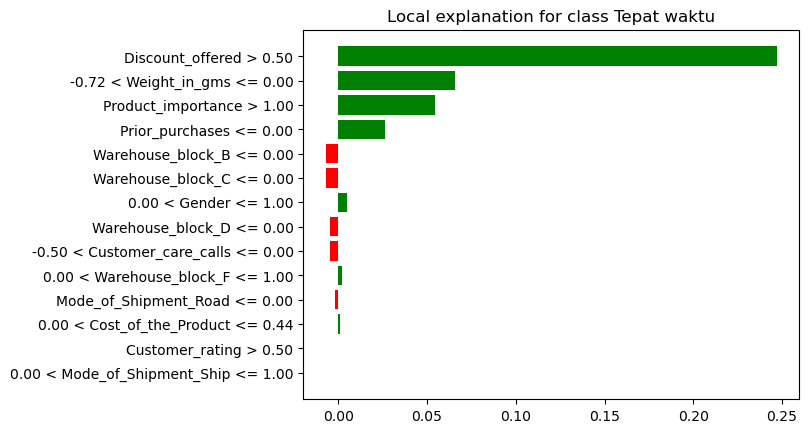

In [86]:
# Try to index 0 of X_test
# Lets compare with the real result
print(f"Barang diprediksi : {('Tepat Waktu' if y_test.iloc[0] == 1 else 'Terlambat')} (This is from y_test)")

index_customer = 0

# explain to 1 row
exp = explainer_lime.explain_instance(
    data_row= df_prep.iloc[index_customer], 
    predict_fn = my_model.predict_proba, 
    num_features= len(feat)
)

exp.as_pyplot_figure()
plt.show()

### 📊 Interpretasi Hasil LIME - Prediksi: Tepat Waktu
Model memprediksi bahwa barang akan sampai tepat waktu, dan LIME memberikan alasan lokal untuk prediksi ini berdasarkan fitur-fitur yang paling berpengaruh.

### 🟢 Fitur yang Mendukung Prediksi "Tepat Waktu":

| Fitur                       | Penjelasan                                                                                                       |
| --------------------------- | ---------------------------------------------------------------------------------------------------------------- |
| `Discount_offered > 0.50`   | Diskon besar menunjukkan kemungkinan pengiriman cepat, mungkin karena promosi hanya berlaku untuk layanan cepat. |
| `Weight_in_gms (ringan)`    | Barang yang lebih ringan biasanya lebih cepat diproses dan dikirim.                                              |
| `Product_importance > 1.00` | Produk penting kemungkinan diprioritaskan dalam proses pengiriman.                                               |
| `Prior_purchases <= 0.00`   | Pelanggan baru bisa mendapatkan prioritas layanan yang lebih baik.                                               |

### 🔴 Fitur yang Menghambat Prediksi "Tepat Waktu":
| Fitur                           | Penjelasan                                                             |
| ------------------------------- | ---------------------------------------------------------------------- |
| `Warehouse_block_B/C/D <= 0.00` | Beberapa blok gudang diasosiasikan dengan keterlambatan pengiriman.    |
| `Customer_care_calls rendah`    | Kurangnya interaksi bisa menandakan kurang perhatian terhadap masalah. |
| `Mode_of_Shipment_Road <= 0.00` | Pengiriman melalui jalur darat cenderung lebih lambat dibanding udara. |

### 📌 Kesimpulan:
Model memprediksi "Tepat Waktu" karena kontribusi positif yang kuat dari diskon besar, bobot barang ringan, dan pentingnya produk. Meskipun ada fitur-fitur negatif seperti asal warehouse atau moda pengiriman, pengaruhnya relatif kecil terhadap prediksi akhir.

In [87]:
# Lets compare with the real result
print(f"Barang diprediksi : {('Tepat Waktu' if y_test.iloc[0] == 1 else 'Terlambat')} (This is from y_test)")

exp = explainer_lime.explain_instance(
    data_row= df_prep.iloc[index_customer], 
    predict_fn= my_model.predict_proba
)

exp.show_in_notebook(show_table=True)

Barang diprediksi : Tepat Waktu (This is from y_test)


### Laporan Interpretasi Prediksi dengan LIME

### 📦 Prediksi: **Tepat Waktu**

Model memprediksi dengan probabilitas **0.87** bahwa barang akan sampai **tepat waktu**.

### Probabilitas Kelas

* **Tepat Waktu**: 0.87
* **Terlambat**: 0.13

Model sangat yakin bahwa pengiriman akan **tepat waktu**, berdasarkan kombinasi fitur input yang dianalisis oleh LIME.

---

### ✅ Fitur Pendukung Prediksi "Tepat Waktu" (Warna Oranye)

| Fitur                           | Kontribusi | Nilai | Penjelasan Singkat                                                 |
| ------------------------------- | ---------- | ----- | ------------------------------------------------------------------ |
| `Discount_offered > 0.50`       | 0.25       | 3.17  | Diskon tinggi, kemungkinan layanan ekspres atau promo khusus.      |
| `-0.72 < Weight_in_gms <= 0`    | 0.06       | -0.65 | Barang cukup ringan, lebih cepat diproses.                         |
| `Product_importance > 1.00`     | 0.05       | 2.00  | Produk sangat penting, jadi diprioritaskan dalam pengiriman.       |
| `Prior_purchases <= 0.00`       | 0.02       | 0.00  | Mungkin pelanggan baru → bisa jadi mendapat perhatian lebih.       |
| `Mode_of_Shipment_Road <= 0.00` | 0.01       | 0.00  | Tidak dikirim via darat, kemungkinan udara atau kapal lebih cepat. |
| `Warehouse_block_F = 1.00`      | 0.01       | 1.00  | Gudang ini mungkin punya performa pengiriman yang lebih baik.      |
| `Customer_rating > 0.50`        | 0.01       | 1.00  | Pelanggan dengan rating baik → bisa dianggap lebih terpercaya.     |
| `Gender = 1.00`                 | 0.01       | 1.00  | Tidak terlalu signifikan, sedikit mendukung.                       |

---

### ❌ Fitur yang Mengurangi Kemungkinan "Tepat Waktu" (Warna Biru)

| Fitur                      | Kontribusi | Nilai             | Penjelasan                                  |
| -------------------------- | ---------- | ----------------- | ------------------------------------------- |
| `Warehouse_block_D = 0.00` | 0.01       | Tidak dari blok D | Blok D kemungkinan memiliki performa buruk. |
| `Warehouse_block_B = 0.00` | 0.00       | Tidak dari blok B | Efeknya sangat kecil / netral.              |

---

### 📌 Kesimpulan

* Prediksi **"Tepat Waktu"** sangat kuat (**87%**) dan didukung oleh **diskon besar, produk ringan, dan pentingnya produk**.
* Faktor negatif seperti lokasi gudang **tidak signifikan** dalam kasus ini.
* Model cukup yakin, menunjukkan bahwa data ini **selaras dengan pola pelatihan model**.



## **13. Kesimpulan dan Rekomendasi**

### 📌Kesimpulan
- Model machine learning yang dibangun mampu memprediksi keterlambatan pengiriman dengan cukup baik, terutama dengan fokus pada recall untuk meminimalkan false negative, yang paling merugikan perusahaan. Nilai recall model yang didapat adalah 75%, ini berarti 3 dari 4 keterlambatan sudah terdeteksi oleh model, sehingga sudah dapat menurunkan kerugian perusahaan.
- Kerugian perusahaan
    + Sebelum menggunakan Model ML
        + Kita tidak bisa mendeteksi keterlambatan, sehingga semua 4436 kasus keterlambatan berjalan tanpa intervensi.
        + Total kerugian: 4436 x $300 = $1.330.800
    + Setelah menggunakan Model ML
        + Total FP = 467 × 0 = 0
        + Total FN = 329 × $300 = $98.700
        + Total Kerugian = Total FP + Total FN
                = 0 + Rp $98.700
                = $98.700
    + ML berhasil menurunkan kerugian sebesar:
**92.6% → ($1.330.800 -  $98.700) / $1.330.800**
- Faktor-faktor yang mempengaruhi ketepatan waktu pengiriman:
    + Diskon besar, berat barang yang ringan, dan produk dengan tingkat kepentingan tinggi terbukti berkontribusi besar terhadap pengiriman tepat waktu.
    + Faktor seperti blok gudang dan mode pengiriman memiliki kontribusi, tapi dampaknya relatif kecil.



### 📍Rekomendasi
- Integrasikan model ke dalam proses order fulfillment untuk mendeteksi dini pengiriman yang berisiko terlambat, agar bisa dilakukan intervensi atau notifikasi ke pelanggan.
- Utamakan pengiriman produk penting dan pelanggan baru atau dengan rating tinggi untuk mempertahankan kepuasan.
- Lakukan audit terhadap performa setiap gudang dan moda pengiriman, terutama gudang dengan performa di bawah rata-rata (misalnya blok D), agar distribusi barang lebih efisien.
- Gunakan diskon sebagai insentif untuk mendorong penggunaan jalur pengiriman yang lebih cepat dan andal.
- Manfaatkan LIME atau SHAP untuk interpretasi lokal prediksi model, guna menjelaskan hasil ke tim operasional dan meningkatkan kepercayaan dalam penggunaan model.

